In [1]:
#Reading Libraries
import lightgbm as lgb
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
import matplotlib.pyplot as plt, os
from matplotlib import patches
import seaborn as sns
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Amex metric
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

# LGBM amex metric
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

In [4]:
def remove_missing_val(df, threshold = 0.5):
    missing_props = df.isna().mean(axis=0)
    #print(missing_props)
    drop_features = missing_props[missing_props>=threshold].index
    print(drop_features)
    df.drop(drop_features, axis = 1, inplace = True)
    return df

def get_not_used():
    # cid is the label encode of customer_ID
    # row_id indicates the order of rows
    return ['row_id', 'customer_ID', 'target', 'cid', 'S_2']
    
def preprocess(df):
    df['row_id'] = np.arange(df.shape[0])
    not_used = get_not_used()
    cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
                'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    
    op1 = ['P_2']+['B_'+ f'{num}' for num in [12, 13, 18, 2, 33, 42]] + ['D_'+ f'{num}' for num in [106, 49, 71, 77, 47]]
    op2 = ['B_'+ f'{num}' for num in [1, 7, 11, 23, 37, 4, 16]] + ['D_55', 'D_48']
    '''
    for col in df.columns:
        if col not in not_used+cat_cols:
            df[col] = df[col].round(2)
    '''
    # compute "after pay" features
    for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
        for pcol in ['P_2','P_3']:
            if bcol in df.columns:
                df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]

    df['S_2'] = pd.to_datetime(df['S_2'])
    df['cid'], _ = df.customer_ID.factorize()
        
    num_cols = [col for col in df.columns if col not in cat_cols+not_used]
    
    
    #option1# dgs = add_stats_step(df, num_cols)
    #option 2
    df_num_agg = df.groupby("customer_ID")[num_cols].agg(['mean', 'std', 'min', 'max', 'last'])
    df_num_agg.columns = ['_'.join(x) for x in df_num_agg.columns]
    df_num_agg.reset_index(inplace = True)
    df_cat_agg = df.groupby("customer_ID")[cat_cols].agg(['count', 'last', 'nunique'])
    df_cat_agg.columns = ['_'.join(x) for x in df_cat_agg.columns]
    df_cat_agg.reset_index(inplace = True)
    
    #Transform 
    cols = list(df_num_agg.dtypes[df_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        df_num_agg[col] = df_num_agg[col].astype(np.float32)
    cols = list(df_cat_agg.dtypes[df_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        df_cat_agg[col] = df_cat_agg[col].astype(np.int32)
    
    df_diff = get_difference(df, num_cols)
    df = df_num_agg.merge(df_cat_agg, how = 'inner', on = 'customer_ID').merge(df_diff, how = 'inner', on = 'customer_ID')
    
    #added
    cat_cols = [f"{cf}_last" for cf in cat_cols]
    
    for cat_col in cat_cols:
        encoder = LabelEncoder()
        df[cat_col] = encoder.fit_transform(df[cat_col])
    num_cols = list(df.dtypes[(df.dtypes == 'float32') | (df.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        df[col + '_round2'] = df[col].round(2)
        
    num_cols = [col for col in df.columns if 'last' in col]
    num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    for col in num_cols:
        try:
            df[f'{col}_last_mean_diff'] = df[f'{col}_last'] - df[f'{col}_mean']
        except:
            pass
        
    num_cols = list(df.dtypes[(df.dtypes == 'float32') | (df.dtypes == 'float64')].index)
    for col in tqdm(num_cols):
        df[col] = df[col].astype(np.float16)
    
    return df

def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    return df1

def add_stats_step(df, cols):
    n = 50
    dgs = []
    for i in range(0,len(cols),n):
        s = i
        e = min(s+n, len(cols))
        dg = add_stats_one_shot(df, cols[s:e])
        dgs.append(dg)
    return dgs

def add_stats_one_shot(df, cols):
    stats = ['mean','std']
    dg = df.groupby('customer_ID').agg({col:stats for col in cols})
    out_cols = []
    for col in cols:
        out_cols.extend([f'{col}_{s}' for s in stats])
    dg.columns = out_cols
    dg = dg.reset_index()
    return dg

def load_test_iter(features, chunks=4):
    
    test_rows = 11363762

    chunk_rows = test_rows // chunks
    
    test = pd.read_parquet(f'test.parquet',
                             columns=['customer_ID','S_2'])
  
    ###modified
    test = test.iloc[:test_rows]
    
    test = get_segment(test)
    start = 0
    while start < test.shape[0]:
        if start+chunk_rows < test.shape[0]:
            end = test['cus_count'].values[start+chunk_rows]
        else:
            end = test['cus_count'].values[-1]
        end = int(end)
        df = pd.read_parquet(f'test.parquet')
        
        ###modified
        df = df.iloc[start:end]
        
        start = end
        yield process_test_data(df, features)

def load_test():
    test = pd.read_parquet(f'train.parquet')
    return process_data(test)

def load_train():
    train = pd.read_parquet(f'train.parquet')
    #train = pd.read_csv(f'my_train_data.csv')
    train, features = process_data(train)
    trainl = pd.read_csv(f'train_labels.csv')
    train = train.merge(trainl, on='customer_ID', how='left')
    return train, features

def process_data(df):
    df= preprocess(df)
    return df, df.columns

def process_test_data(df, features):
    df= preprocess(df)
    drop_cols = [col for col in df.columns if col not in features]
    df = df.drop(drop_cols, axis = 1)
    return df

def get_segment(test):
    dg = test.groupby('customer_ID').agg({'S_2':'count'})
    dg.columns = ['cus_count']
    dg = dg.reset_index()
    dg['cid'],_ = dg['customer_ID'].factorize()
    dg = dg.sort_values('cid')
    dg['cus_count'] = dg['cus_count'].cumsum()
    
    test = test.merge(dg, on='customer_ID', how='left')
    test = test.sort_values(['cid','S_2'])
    assert test['cus_count'].values[-1] == test.shape[0]
    return test

In [5]:
#Load Train Data
train, features = load_train()
test = pd.read_parquet(f'test.parquet')
test = process_test_data(test, features)

100%|█████████████████████████████████████████| 275/275 [00:17<00:00, 15.29it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████| 275/275 [00:28<00:00,  9.79it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████| 1192/1192 [01:39<00:00, 12.04it/s]


In [6]:
#LightGBM Parameters
seed = 42
folds = 4
lgbparams = {
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'dart',
        'seed': seed,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40
        }

In [7]:
#Drop features that are not used
not_used = get_not_used()
not_used = [i for i in not_used if i in train.columns]
train_x, train_y = train.drop(not_used, axis=1), train['target']
features = train_x.columns.tolist()
cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68"
    ]
cat_features = [f"{cf}_last" for cf in cat_features]

In [8]:
# Create a numpy array to store test predictions
test_predictions = np.zeros(len(test))

# Create a numpy array to store out of folds predictions
oof_predictions = np.zeros(len(train))

kfold = StratifiedKFold(n_splits = folds, shuffle = True, random_state = seed)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_x, train_y)):
    
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {len(features)} features...')
    x_train, x_val = train_x[features].iloc[trn_ind], train_x[features].iloc[val_ind]
    y_train, y_val = train_y.iloc[trn_ind], train_y.iloc[val_ind]
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
    model = lgb.train(
        params = lgbparams,
        train_set = lgb_train,
        num_boost_round = 10500,
        #num_boost_round = 50,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 100,
        verbose_eval = 500,
        feval = lgb_amex_metric
        )

    # Predict validation
    val_pred = model.predict(x_val)
    
    # Add to out of folds array
    oof_predictions[val_ind] = val_pred
    
    # Predict the test set
    test_pred = model.predict(test[features])
    test_predictions += test_pred / folds
    
    # Compute fold metric
    score = amex_metric(y_val, val_pred)
    print(f'Our fold {fold} CV score is {score}')
    del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
    gc.collect()

 
--------------------------------------------------
Training fold 0 with 1477 features...
[LightGBM] [Info] Number of positive: 89121, number of negative: 255063
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252664
[LightGBM] [Info] Number of data points in the train set: 344184, number of used features: 1469
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258934 -> initscore=-1.051516
[LightGBM] [Info] Start training from score -1.051516
[500]	training's binary_logloss: 0.334836	training's amex_metric: 0.779628	valid_1's binary_logloss: 0.336656	valid_1's amex_metric: 0.772428
[1000]	training's binary_logloss: 0.244421	training's amex_metric: 0.79604	valid_1's binary_logloss: 0.250058	valid_1's amex_metric: 0.782894
[1500]	training's binary_logloss: 0.220503	training's amex

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

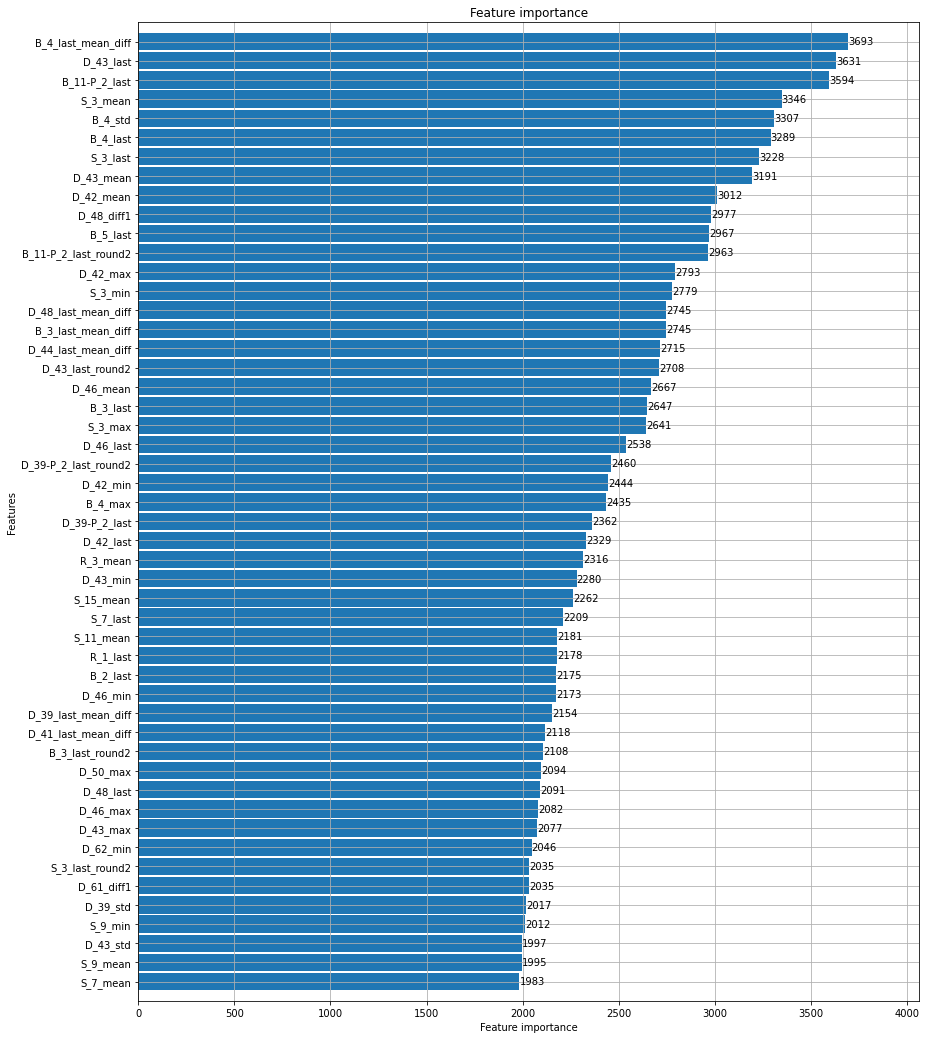

In [9]:
lgb.plot_importance(model, max_num_features = 50, height=0.9, figsize=(14, 18))

In [10]:
# Compute out of folds metric
score = amex_metric(train_y, oof_predictions)
print(f'Our out of folds CV score is {score}')
# Create a dataframe to store out of folds predictions
#oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
#oof_df.to_csv(f'/content/drive/MyDrive/Amex/OOF/oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
# Create a dataframe to store test prediction
test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
test_df.to_csv('sub_lgbm.csv', index = False)

Our out of folds CV score is 0.796142004486033


In [12]:
test_df

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.325867
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.290169
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.292390
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.390536
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.478985
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.297715
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.444643
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.438963
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.353905
